# Modeling - Univariate time series model (single wind farm)

This notebook focuses on stage 1 of modeling for this project: modeling power output at one wind farm, using a time series model that is built purely on previous power output.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import arma_order_select_ic

In [3]:
from sklearn.metrics import mean_squared_error

In [4]:
from ipywidgets import interact, FloatSlider, Dropdown

In [5]:
# read in data

power_train = pd.read_csv('../datasets/power_train.csv', index_col=0)
power_train.index = pd.DatetimeIndex(power_train.index, freq='H')

power_val_data = pd.read_csv('../datasets/power_val_data.csv', index_col=0)
power_val_data.index = pd.DatetimeIndex(power_val_data.index)

power_val_target = pd.read_csv('../datasets/power_val_target.csv', index_col=0)
power_val_target.index = pd.DatetimeIndex(power_val_target.index)

power_val_benchmark = pd.read_csv('../datasets/power_val_benchmark.csv', index_col=0)
power_val_benchmark.index = pd.DatetimeIndex(power_val_benchmark.index)

# restrict analysis to one wind farm

wp1_train = power_train['wp1']
wp1_val_data = power_val_data['wp1']
wp1_val_target = power_val_target['wp1']
wp1_val_benchmark = power_val_benchmark['wp1']

## Auto-correlation

In [6]:
# look at ACF and PACF plots

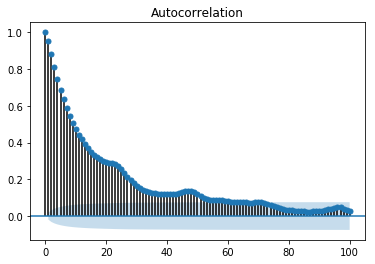

In [7]:
plot_acf(wp1_train, lags=100);

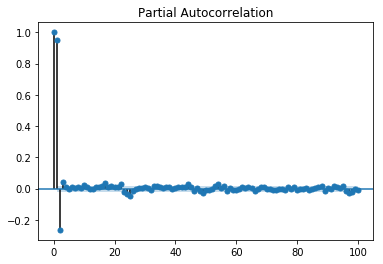

In [8]:
plot_pacf(wp1_train, lags=100);

In [9]:
# PACF has a sharp cut-off after 2 lags, and the lag-1 ACF is positive
# this signature is suggestive of a AR(2) model

## Fit AR(2) model

In [10]:
p = 2 # num of autoregressive terms
q = 0 # num of MA terms

# use SARIMAX for additional functionality later on
ar2 = sarimax.SARIMAX(endog = wp1_train, order = (p,0,q)).fit()
ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    wp1   No. Observations:                10453
Model:               SARIMAX(2, 0, 0)   Log Likelihood               13011.246
Date:                Sun, 15 Jul 2018   AIC                         -26016.491
Time:                        23:13:08   BIC                         -25994.727
Sample:                    07-01-2009   HQIC                        -26009.140
                         - 09-09-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2183      0.006    219.353      0.000       1.207       1.229
ar.L2         -0.2487      0.006    -43.911      0.000      -0.260      -0.238
sigma2         0.0049    3.4e-05    142.852      0.000       0.005       0.005
===================================================================================
Ljung-Box (Q):                      189.87   Jarque-Bera (JB):             18245.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Test model

#### Create model prediction functions

In [11]:
def forecast_48_from_36(model, data):
    
    '''forecasts 48 hours of power output given one 36 hour window of available data'''
    
    # reset index frequency to hourly - this was lost before when slicing up the date-time index
    # need this so the model knows how frequently to make predictions
    data.index = pd.DatetimeIndex(data.index, freq='H')
    # reinstantiate model, but use old parameters
    p = model.model_orders['ar']
    q = model.model_orders['ma']
    model_temp = sarimax.SARIMAX(endog = data, order = (p,0,q))
    model_temp = model_temp.filter(model.params)
    # forecast
    return model_temp.get_forecast(48)


In [12]:
def make_forecasts(model, data_series):
        
    '''forecasts many sets of 48 hours of power output given repeated 36 hour windows of available data'''
    
    predictions = []
    num_patterns = int(data_series.shape[0]/36) # 36 hours of data, followed by 48 hour gaps
    
    for pattern_num in range(num_patterns):
        data = data_series[36*pattern_num:36*(pattern_num+1)]
        forecast = forecast_48_from_36(model, data).predicted_mean
        predictions.extend(forecast)
    
    ix = pd.DatetimeIndex(start=data_series.index[0], end=data_series.index[-1]+pd.Timedelta(hours=48), freq='H')
    forecast_ix = [date for date in ix if date not in data_series.index]
    
    return pd.DataFrame(predictions, columns=['forecast'], index = forecast_ix)

#### Test AR(2) model

In [13]:
ar2_predictions = make_forecasts(ar2, wp1_val_data)
ar2_RMSE = mean_squared_error(y_true = wp1_val_target, y_pred = ar2_predictions)**0.5
print('AR2 model RMSE:', ar2_RMSE)

AR2 model RMSE: 0.27257073982283336


In [14]:
# shows improvement of ~13% on baseline

## Search for best ARMA model

### AIC and BIC

In this section, the AIC (Akaike information criterion) and BIC (Bayesian information criterion) are used to determine the 'best' model.

**Aside:**

> AIC and BIC are two different ways of assessing the fit of the model, whilst penalising high numbers of parameters, so as to prevent overfitting. The formulae are as follows: $$ AIC = -2\log L + 2p $$ $$ BIC =  -2\log L + p\log n$$   where: 
- $L$ is the likelihood 
- $p$ is the number of parameters 
- $n$ is the number of observations.


> <br>A key difference between the AIC and BIC is that the penalty for additional parameters for BIC is greater than for the penalty under AIC. The AIC is therefore more likely to find an overfit model, and the BIC find an underfit model, and therefore it can be useful to look at both when choosing a model.

In [15]:
# investigate AICs for various p,q values
arma_order_select_ic(wp1_train, max_ar = 4, max_ma = 2, ic= 'aic')

{'aic':               0             1             2
 0   -944.566282 -11991.487060 -18189.642757
 1 -25481.108341 -26233.858324 -26251.855806
 2 -26236.753238 -26250.240528 -26250.498158
 3 -26251.571410 -26250.252761 -26248.741777
 4 -26250.284497 -26249.232003 -26248.160681, 'aic_min_order': (1, 2)}

In [16]:
# investigate BICs for various p,q values
arma_order_select_ic(wp1_train, max_ar = 4, max_ma = 2, ic= 'bic')

{'bic':               0             1             2
 0   -930.056993 -11969.723127 -18160.624180
 1 -25459.344409 -26204.839747 -26215.582584
 2 -26207.734661 -26213.967306 -26206.970292
 3 -26215.298189 -26206.724895 -26197.959267
 4 -26206.756631 -26198.449493 -26190.123526, 'bic_min_order': (1, 2)}

In [17]:
# both information criterions suggest an AR(1)MA(2) model will fit best, so try this
ar1ma2 = sarimax.SARIMAX(endog = wp1_train, order = (1,0,2)).fit()
ar1ma2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    wp1   No. Observations:                10453
Model:               SARIMAX(1, 0, 2)   Log Likelihood               13027.181
Date:                Sun, 15 Jul 2018   AIC                         -26046.363
Time:                        23:14:55   BIC                         -26017.344
Sample:                    07-01-2009   HQIC                        -26036.562
                         - 09-09-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9627      0.002    437.366      0.000       0.958       0.967
ma.L1          0.2699      0.006     45.393      0.000       0.258       0.282
ma.L2          0.0253      0.007      3.615      0.000       0.012       0.039
sigma2         0.0048   3.41e-05    142.067      0.000       0.005       0.005
===================================================================================
Ljung-Box (Q):                      169.81   Jarque-Bera (JB):             18280.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
ar1ma2_predictions = make_forecasts(ar1ma2, wp1_val_data)
ar1ma2_RMSE = mean_squared_error(y_true = wp1_val_target, y_pred = ar1ma2_predictions)**0.5
print('AR(1)MA(2) model RMSE:', ar1ma2_RMSE)

AR(1)MA(2) model RMSE: 0.2692979752738075


In [19]:
# shows improvement of ~14% on baseline

### RMSE

In this section, the RMSE is used to determine the 'best' model.

In [20]:
# evaluate combinations of p, d and q values for an ARIMA model
def find_best_ARIMA_params(training_data, testing_data, target, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try: # use a try clause as MA models can't always find a solution
                    np.random.seed(42)
                    model = sarimax.SARIMAX(endog = training_data, order = order).fit()
                    if model.mle_retvals['converged']: # only use solution if converged
                        preds = make_forecasts(model, testing_data)
                        rmse = mean_squared_error(y_true = target, y_pred = preds)**0.5
                        if rmse < best_score:
                            best_score, best_cfg = rmse, order
                        print('ARIMA%s RMSE=%.3f' % (str(order), rmse))
                    else:
                        print('ARIMA%s failed to converge' % (str(order)))
                except:
                    print('ARIMA%s could not find a solution' % (str(order)))
    print('\nBest ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg
    
# code adapted from: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

In [21]:
import warnings
warnings.filterwarnings('ignore') # suppress convergence warnings

best_params = find_best_ARIMA_params(training_data = wp1_train, 
                       testing_data = wp1_val_data,
                       target = wp1_val_target,
                       p_values = [0,1,2,3,4],
                       d_values = [0],
                       q_values = [0,1,2])

warnings.filterwarnings('default') # turn warnings back on

ARIMA(0, 0, 0) RMSE=0.385
ARIMA(0, 0, 1) could not find a solution
ARIMA(0, 0, 2) could not find a solution
ARIMA(1, 0, 0) RMSE=0.261
ARIMA(1, 0, 1) RMSE=0.269
ARIMA(1, 0, 2) RMSE=0.269
ARIMA(2, 0, 0) RMSE=0.273
ARIMA(2, 0, 1) RMSE=0.272
ARIMA(2, 0, 2) RMSE=0.268
ARIMA(3, 0, 0) RMSE=0.268
ARIMA(3, 0, 1) failed to converge
ARIMA(3, 0, 2) failed to converge
ARIMA(4, 0, 0) RMSE=0.267
ARIMA(4, 0, 1) RMSE=0.268
ARIMA(4, 0, 2) could not find a solution

Best ARIMA(1, 0, 0) RMSE=0.261


In [22]:
# AR(1) performs best

In [23]:
ar1 = sarimax.SARIMAX(endog = wp1_train, order = (1,0,0)).fit()
ar1.summary()

/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    wp1   No. Observations:                10453
Model:               SARIMAX(1, 0, 0)   Log Likelihood               12677.612
Date:                Sun, 15 Jul 2018   AIC                         -25351.223
Time:                        23:15:21   BIC                         -25336.714
Sample:                    07-01-2009   HQIC                        -25346.323
                         - 09-09-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9757      0.002    591.730      0.000       0.972       0.979
sigma2         0.0052   3.79e-05    136.432      0.000       0.005       0.005
===================================================================================
Ljung-Box (Q):                      989.03   Jarque-Bera (JB):             11677.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
ar1_predictions = make_forecasts(ar1, wp1_val_data)
ar1_RMSE = mean_squared_error(y_true = wp1_val_target, y_pred = ar1_predictions)**0.5
print('AR(1) model RMSE:', ar1_RMSE)

AR(1) model RMSE: 0.26060029506863364


In [25]:
# shows improvement of ~17% on baseline

## Model diagnostics

So far we have three potential 'best' models: AR1, AR2 and AR1MA2. The plot diagnostic functions allows for comparison on metrics other than the AIC/BIC, RMSE that have been the focus so far.

These metrics are helpful in diagnosing whether the residuals of the model are uncorrelated and normally distributed. If this is not the case, it is likely the model can be improved.

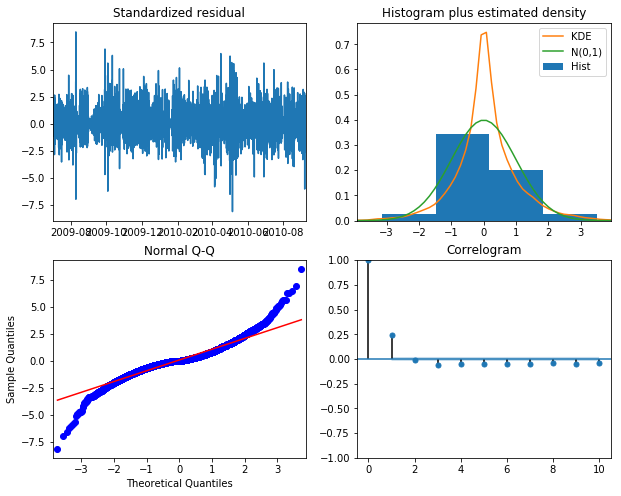

In [26]:
ar1.plot_diagnostics(figsize=(10,8));

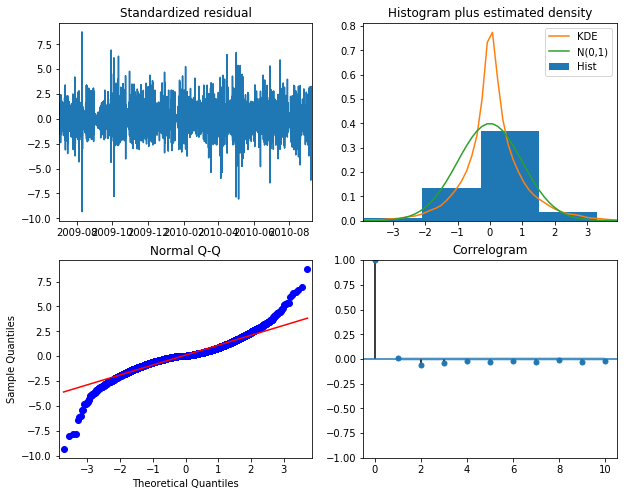

In [27]:
ar2.plot_diagnostics(figsize=(10,8));

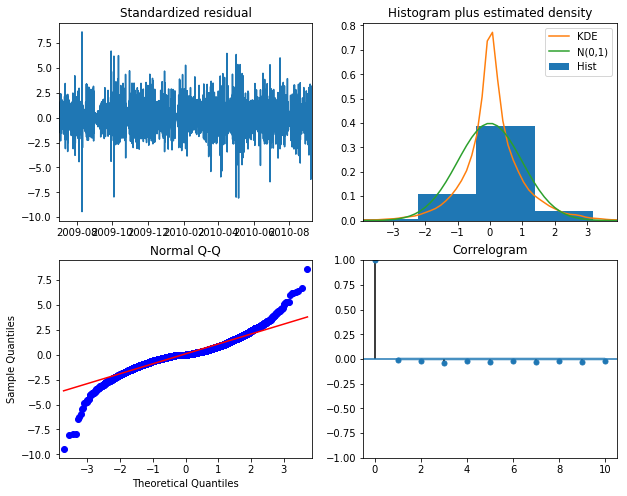

In [28]:
ar1ma2.plot_diagnostics(figsize=(10,8));

The AR1 model stands out here, as the correlogram suggests there is some correlation between lagged residuals. This is not surprising given that the initial ACF and PACF plots were indicative of an AR2 model. Therefore, even though the AR1 model gave a lower RMSE on the test set, it is not as theorectically accurate as the other two models.

All three models show a pattern of residuals that is akin to white noise, with no obvious trends or seasonality (see top-left plot). The residual plot, the histogram and the Q-Q plot show that the residuals have a mean around 0, meaning that the predictions aren't systematically bias and will be correct on average. However, the histograms and Q-Q plots, show that the residuals have a higher kurtosis than a normal distribution would suggest.

In [29]:
# save best model predictions
predictions = make_forecasts(ar2, wp1_val_data)
predictions.to_csv('../datasets/wp1_predictions_sarimax.csv')

## Forecast plot

In [30]:
def make_widget(model, data_series, target_series = None, alt_prediction = None, alt_label = None):
    
    num_patterns = int(data_series.shape[0]/36) # 36 hours of data, followed by 48 hour gaps
    windows = [str(i)+':  '+ str(data_series.index[36*i])+' - '+str(data_series.index[36*(i+1)-1]) for i in range(num_patterns)]
   
    style = {'description_width': 'initial'}
    
    window_select = Dropdown(
    options=windows,
    value=windows[0],
    description='Data window:',
    style = style,
    layout={'width': '400px'}
    )
    
    level_select = FloatSlider(
    value=0.95, min=0.01, max=0.99, step=0.01,
    description='Confidence level:',
    style = style,
    layout={'width': '400px'},
    continuous_update=False,
    )

    
    def plot_widget(data_window = windows[0], conf_level = 0.95):
    
        # filter dataframe
        data_window_int = int(data_window.split(':')[0])
        data = data_series[36*data_window_int:36*(data_window_int+1)]
        forecast = forecast_48_from_36(model, data)
        forecast_mean = forecast.predicted_mean
        conf_int = forecast.conf_int(alpha = (1-conf_level)) 
    
        # plot
        fig, ax = plt.subplots(figsize=(20,6))
        
        data.plot(label='observed data', c='k')
        forecast.predicted_mean.plot(label='ARIMA forecast', ax=ax)
        ax.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], alpha=.2)
        
        if alt_prediction is not None:
            alt_forecast = alt_prediction[48*data_window_int:48*(data_window_int+1)]
            if isinstance(alt_forecast, pd.DataFrame):
                alt_forecast = alt_forecast['forecast']
            alt_forecast.plot(label=alt_label, ax=ax, c='C0', style='--')
                
        if target_series is not None:
            target = target_series[48*data_window_int:48*(data_window_int+1)]
            target.plot(label='target data', ax=ax, c='grey')
            forecast_RMSE = mean_squared_error(y_true = target, y_pred = forecast.predicted_mean)**0.5
            print('ARIMA forecast RMSE:', "{0:.2f}".format(forecast_RMSE))
            if alt_prediction is not None:
                alt_forecast_RMSE = mean_squared_error(y_true = target, y_pred = alt_forecast)**0.5
                print(str(alt_label), 'RMSE:', "{0:.2f}".format(alt_forecast_RMSE))
        
        ax.minorticks_off()
        idx = pd.date_range(data.index[0]-pd.Timedelta(hours=1), forecast.predicted_mean.index[-1], freq='H')
        ax.set_xlim(idx[0],idx[-1])
        ax.set_ylim(0,1)

        ax.set_xticks(idx[::12])
        ax.set_xticklabels(idx[::12].strftime('%Y-%m-%d\n%H:%M:%S'))
        
        plt.title('Observed and forecast power output\n', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Power output\n', fontsize=14)

        plt.legend()
        plt.show()
    
    interact(plot_widget, data_window=window_select, conf_level=level_select);


In [31]:
make_widget(model = ar2, data_series = wp1_val_data, target_series = wp1_val_target,
           alt_prediction = wp1_val_benchmark, alt_label = 'persistence forecast')

interactive(children=(Dropdown(description='Data window:', layout=Layout(width='400px'), options=('0:  2010-09-09 13:00:00 - 2010-09-11 00:00:00', '1:  2010-09-13 01:00:00 - 2010-09-14 12:00:00', '2:  2010-09-16 13:00:00 - 2010-09-18 00:00:00', '3:  2010-09-20 01:00:00 - 2010-09-21 12:00:00', '4:  2010-09-23 13:00:00 - 2010-09-25 00:00:00', '5:  2010-09-27 01:00:00 - 2010-09-28 12:00:00', '6:  2010-09-30 13:00:00 - 2010-10-02 00:00:00', '7:  2010-10-04 01:00:00 - 2010-10-05 12:00:00', '8:  2010-10-07 13:00:00 - 2010-10-09 00:00:00', '9:  2010-10-11 01:00:00 - 2010-10-12 12:00:00', '10:  2010-10-14 13:00:00 - 2010-10-16 00:00:00', '11:  2010-10-18 01:00:00 - 2010-10-19 12:00:00', '12:  2010-10-21 13:00:00 - 2010-10-23 00:00:00', '13:  2010-10-25 01:00:00 - 2010-10-26 12:00:00', '14:  2010-10-28 13:00:00 - 2010-10-30 00:00:00', '15:  2010-11-01 01:00:00 - 2010-11-02 12:00:00', '16:  2010-11-04 13:00:00 - 2010-11-06 00:00:00', '17:  2010-11-08 01:00:00 - 2010-11-09 12:00:00', '18:  2010-11-11 13:00:00 - 2010-11-13 00:00:00', '19:  2010-11-15 01:00:00 - 2010-11-16 12:00:00', '20:  2010-11-18 13:00:00 - 2010-11-20 00:00:00', '21:  2010-11-22 01:00:00 - 2010-11-23 12:00:00', '22:  2010-11-25 13:00:00 - 2010-11-27 00:00:00', '23:  2010-11-29 01:00:00 - 2010-11-30 12:00:00', '24:  2010-12-02 13:00:00 - 2010-12-04 00:00:00', '25:  2010-12-06 01:00:00 - 2010-12-07 12:00:00', '26:  2010-12-09 13:00:00 - 2010-12-11 00:00:00', '27:  2010-12-13 01:00:00 - 2010-12-14 12:00:00', '28:  2010-12-16 13:00:00 - 2010-12-18 00:00:00', '29:  2010-12-20 01:00:00 - 2010-12-21 12:00:00', '30:  2010-12-23 13:00:00 - 2010-12-25 00:00:00', '31:  2010-12-27 01:00:00 - 2010-12-28 12:00:00'), style=DescriptionStyle(description_width='initial'), value='0:  2010-09-09 13:00:00 - 2010-09-11 00:00:00'), FloatSlider(value=0.95, continuous_update=False, description='Confidence level:', layout=Layout(width='400px'), max=0.99, min=0.01, step=0.01, style=SliderStyle(description_width='initial')), Output()), _dom_classes=('widget-interact',))